### 動画内のオブジェクトを検出

In [1]:
import pathlib
from arcgis import learn
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
import cv2

In [9]:
dat_path = Path(r"RoadDamageDataset/Adachi/")

In [10]:
dat = learn.prepare_data(path = dat_path,
                         class_mapping = {"D00": "Liner crack, longitudinal, wheel mark part",
                                          "D01": "Liner crack, longitudinal, construction joint part",
                                          "D10": "Liner crack, lateral,equal interval",
                                          "D11": "Liner crack, lateral, construction joint part",
                                          "D20": "Alligator crack",
                                          "D40": "Rutting, bump, pothole, separation",
                                          "D43": "White line blur",
                                          "D44": "Cross walk blur"},
                         batch_size = 128,
                         chip_size = 450,
                         seed = 42,
                         dataset_type = "PASCAL_VOC_rectangles",
                         resize_to = 450)

Please check your dataset. 58 images dont have the corresponding label files.


In [5]:
dat.classes

['background',
 'Alligator crack',
 'Cross walk blur',
 'Liner crack, lateral, construction joint part',
 'Liner crack, lateral,equal interval',
 'Liner crack, longitudinal, construction joint part',
 'Liner crack, longitudinal, wheel mark part',
 'Rutting, bump, pothole, separation',
 'White line blur']

/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/vision/data.py:306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


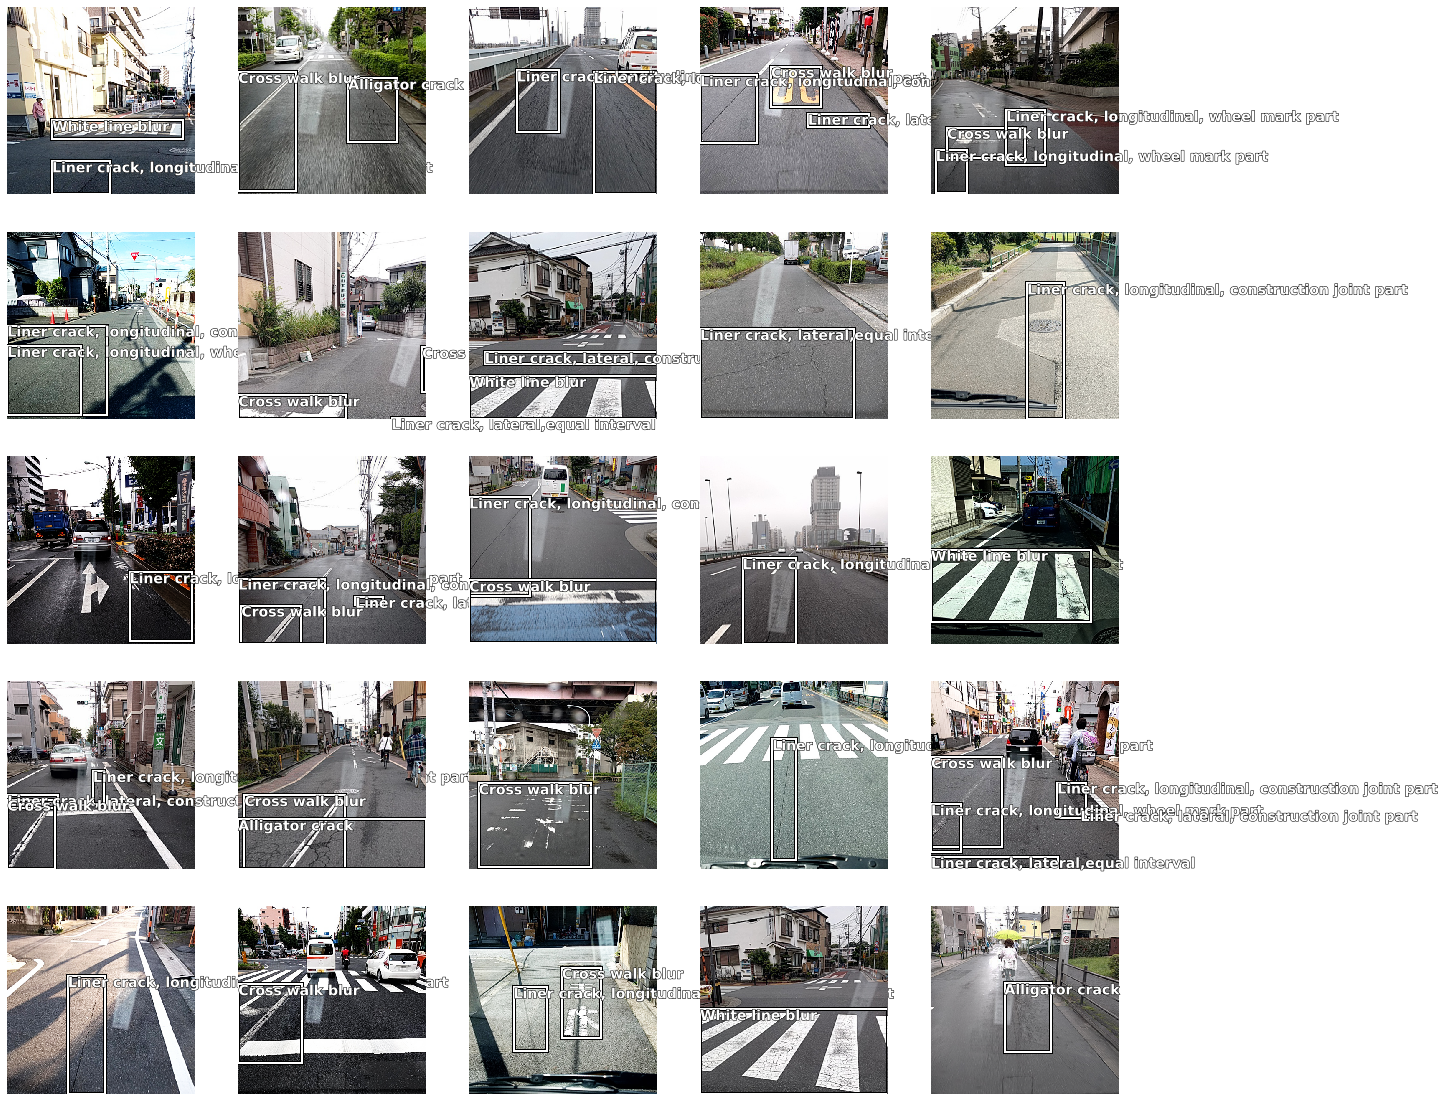

In [23]:
dat.show_batch()

In [11]:
ssd = learn.SingleShotDetector(data = dat,
                               grids = [3, 3],
                               zooms = [1.0],
                               ratios = [[1.0, 1.0]],
                               backbone = "resnet50",
                               focal_loss = True
                              )

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\vmadmin/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|█████████████████████████████████████████████████████████████| 102502400/102502400 [00:00<00:00, 119274725.82it/s]


In [13]:
ssd.load(r"stage-3-fine")

* predict_video()メソッドで動画内のひび割れを検出してバウンディングボックスを書き込みます。
* metadata_fileはMISBの仕様に準拠している必要があります。
    * [詳細はFull Motion Video の概要](https://pro.arcgis.com/ja/pro-app/help/analysis/image-analyst/introduction-to-full-motion-video-in-arcgis-pro.htm)をご確認ください
    * multiplex = True でインプットする動画にメタデータに基づいて[ビデオ マルチプレクサー (Video Multiplexer)](https://pro.arcgis.com/ja/pro-app/tool-reference/image-analyst/video-multiplexer.htm)が実行されますが、実行環境でarcpyが利用できる必要があります。

In [14]:
ssd.predict_video(input_video_path = r"videos/V_20191205_155140_vHDR_On.mp4",
                  metadata_file = r"videos/unixtime_1000.csv",
                  threshold = 0.2,
                  visualize = True,
                  multiplex = True,
                  visual_options = {"show_labels": True,
                                    "thickness": 2})

C:\Users\vmadmin\AppData\Local\ESRI\conda\envs\170fastai\lib\site-packages\arcgis\learn\_video_utils.py:178: UserWarning: Writing 171 rows only!
  warn(f"Writing {len(data)} rows only!")


In [225]:
# メタデータのファイルにvmtilocaldatasetが書き込まれるため、それを使って検出されたバウンディングボックスの数を可視化
import pandas as pd
df = pd.read_csv(r"videos/unixtime_1000.csv")
df

UnixTimeStamp  PlatformHeading  PlatformPitch  PlatformRoll  \
0    1575561099675000                0              0             0   
1    1575561100673000                0              0             0   
2    1575561101675000                0              0             0   
3    1575561102670000                0              0             0   
4    1575561103670000                0              0             0   
..                ...              ...            ...           ...   
165  1575561264473000                0              0             0   
166  1575561265472000                0              0             0   
167  1575561266470000                0              0             0   
168  1575561267469000                0              0             0   
169  1575561268470000                0              0             0   

     SensorLatitude  SensorLongitude  SensorAltitude  HorizontalFOV  \
0         35.682519       139.738323               0              0   
1         35.682522       139.738319               0              0   
2         35.682522       139.738319               0              0   
3         35.682528       139.738314               0              0   
4         35.682528       139.738314               0              0   
..              ...              ...             ...            ...   
165       35.681477       139.739440               0              0   
166       35.681477       139.739440               0              0   
167       35.681449       139.739439               0              0   
168       35.681449       139.739439               0              0   
169       35.681428       139.739438               0              0   

     VerticalFOV  SensorRelativeAzimuth  SensorRelativeElevation  \
0              0                      0                        0   
1              0                      0                        0   
2              0                      0                        0   
3              0                      0                        0   
4              0                      0                        0   
..           ...                    ...                      ...   
165            0                      0                        0   
166            0                      0                        0   
167            0                      0                        0   
168            0                      0                        0   
169            0                      0                        0   

     SensorRelativeRoll                                 vmtilocaldataset  
0                     0  1 53.978508710861206 1024112 2042051 1535001;\n  
1                     0  1 53.844767808914185 1014500 2036282 1525391;\n  
2                     0   1 52.32471227645874 1004885 2028594 1517699;\n  
3                     0  1 59.261977672576904 1024099 2045879 1534988;\n  
4                     0   1 56.97423815727234 1024117 2045894 1535005;\n  
..                  ...                                              ...  
165                   0                                               \n  
166                   0                                               \n  
167                   0                                               \n  
168                   0                                               \n  
169                   0                                               \n  

[170 rows x 13 columns]

---

In [226]:
# vmtilocaldataset列をスペースで分割
vmtis = df.vmtilocaldataset.str.split(" ", expand = True)
# バウンディングボックスの値のみ抜き出す
num_detected = vmtis.iloc[:, 0]
num_detected.name = "num_detected"

In [227]:
# 既存のDFと結合して改行値は0で埋める
new = pd.concat([df, num_detected], axis=1).\
        drop("vmtilocaldataset", axis = 1).\
        replace({"num_detected": {"\n": 0}})

In [228]:
# データ型を整数値に変換
new.num_detected = new.num_detected.astype("int")

In [1]:
from arcgis.features import GeoAccessor
from arcgis.gis import GIS

In [2]:
gis = GIS("https://nakamura-dev-org.maps.arcgis.com", "nakamura_dev_org")

Enter password: ········


In [229]:
# Spatially Enabled DataFrameに変換
crack_sedf = GeoAccessor.from_xy(new, x_column = "SensorLongitude", y_column = "SensorLatitude")

In [230]:
# Unix時間をdatetimeに変換
crack_sedf.UnixTimeStamp = crack_sedf.UnixTimeStamp/1000000
crack_sedf.UnixTimeStamp = pd.to_datetime(crack_sedf.UnixTimeStamp.astype(int), unit = "s", utc = True)

In [231]:
crack_sedf.head()

UnixTimeStamp  PlatformHeading  PlatformPitch  PlatformRoll  \
0 2019-12-05 15:51:39+00:00                0              0             0   
1 2019-12-05 15:51:40+00:00                0              0             0   
2 2019-12-05 15:51:41+00:00                0              0             0   
3 2019-12-05 15:51:42+00:00                0              0             0   
4 2019-12-05 15:51:43+00:00                0              0             0   

   SensorLatitude  SensorLongitude  SensorAltitude  HorizontalFOV  \
0       35.682519       139.738323               0              0   
1       35.682522       139.738319               0              0   
2       35.682522       139.738319               0              0   
3       35.682528       139.738314               0              0   
4       35.682528       139.738314               0              0   

   VerticalFOV  SensorRelativeAzimuth  SensorRelativeElevation  \
0            0                      0                        0   
1            0                      0                        0   
2            0                      0                        0   
3            0                      0                        0   
4            0                      0                        0   

   SensorRelativeRoll  num_detected  \
0                   0             1   
1                   0             1   
2                   0             1   
3                   0             1   
4                   0             1   

                                               SHAPE  
0  {'x': 139.7383232, 'y': 35.68251865, 'spatialR...  
1  {'x': 139.73831940000002, 'y': 35.68252217, 's...  
2  {'x': 139.73831940000002, 'y': 35.68252217, 's...  
3  {'x': 139.7383144, 'y': 35.68252753, 'spatialR...  
4  {'x': 139.7383144, 'y': 35.68252753, 'spatialR...

In [232]:
# フィーチャ サービスとしてアップロード
crack_sedf.spatial.to_featurelayer(title = "crack_detection_3",
                                   gis = gis,
                                   tags = ["road_crack", "deep_learning", "dev_seminar"],
                                   folder = "road_crack")

<Item title:"crack_detection_3" type:Feature Layer Collection owner:nakamura_dev_org>

<Item title:"road_crack_from_vmti" type:Dashboard owner:nakamura_dev_org>
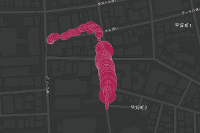

In [3]:
# アップロードしたフィーチャ サービスを元にArcGIS Onlineで作成したダッシュボード
db = gis.content.search("3bac0c58ecff419f91ba174e547e7cb5")[0]
db